In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
data = pd.read_csv('consumption_temp.csv')
data['time']= pd.to_datetime(data['time'])
data['dayofweek'] = data['time'].dt.day_name()
data['weeknumber'] = data['time'].dt.isocalendar().week
data['weeknumber'] = data['weeknumber'].astype("int")
data['hour'] = data['time'].dt.hour

In [154]:
data.head()

,time,location,consumption,temperature,dayofweek,weeknumber,hour
0,2022-04-07 21:00:00,bergen,1.113325,-0.3,Thursday,14,21
1,2022-04-07 21:00:00,oslo,4.092830,1.0,Thursday,14,21
2,2022-04-07 21:00:00,stavanger,2.057858,1.3,Thursday,14,21
3,2022-04-07 21:00:00,tromsø,1.246582,-3.9,Thursday,14,21
4,2022-04-07 21:00:00,trondheim,1.970098,-2.8,Thursday,14,21


In [3]:
data.set_index('time', drop=True, inplace=True)
df = data[data['location'] != 'helsingfors']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43205 entries, 2022-04-07 21:00:00 to 2023-04-02 21:00:00
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   location     43205 non-null  object 
 1   consumption  43205 non-null  float64
 2   temperature  43205 non-null  float64
 3   dayofweek    43205 non-null  object 
 4   weeknumber   43205 non-null  int64  
 5   hour         43205 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 2.3+ MB


In [4]:
# Function to add lag features
def add_lag_features(df, target_column, lag_values):
    for lag in lag_values:
        df[f'{target_column}_lag_{(lag)}h'] = df.groupby('location')[target_column].shift(lag)

# Lag values for 1, 2, 3, and 4 weeks
lag_values_weeks = [168, 336, 504, 672]
# Lag values for 1, 2, and 7 days
lag_values_days = [24, 48, 168]

# Add lag features for the 'target' column
add_lag_features(df, 'consumption', lag_values_weeks)
add_lag_features(df, 'temperature', lag_values_days)

/var/folders/5t/4l6fvdsd6hd9vvy7c6sy1f5r0000gn/T/ipykernel_79027/3858027703.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{target_column}_lag_{(lag)}h'] = df.groupby('location')[target_column].shift(lag)


In [182]:
df[(df['dayofweek'] == 'Sunday') & (df['hour'] == 1) & (df['location'] == 'bergen')].head(6)

,location,consumption,temperature,dayofweek,weeknumber,hour,consumption_lag_168h,consumption_lag_336h,consumption_lag_504h,consumption_lag_672h,temperature_lag_24h,temperature_lag_48h,temperature_lag_72h,temperature_lag_96h
time,,,,,,,,,,,,,,
2022-04-10 01:00:00,bergen,0.982427,1.9,Sunday,14,1,NaN,NaN,NaN,NaN,1.0,-0.7,NaN,NaN
2022-04-17 01:00:00,bergen,0.804600,4.2,Sunday,15,1,0.982427,NaN,NaN,NaN,3.5,4.5,5.2,2.9
2022-04-24 01:00:00,bergen,0.569457,3.7,Sunday,16,1,0.804600,0.982427,NaN,NaN,6.1,5.3,4.2,3.7
2022-05-01 01:00:00,bergen,0.666775,2.9,Sunday,17,1,0.569457,0.804600,0.982427,NaN,4.8,1.9,4.1,3.5
2022-05-08 01:00:00,bergen,0.702429,2.3,Sunday,18,1,0.666775,0.569457,0.804600,0.982427,6.0,8.0,7.0,3.3
2022-05-15 01:00:00,bergen,0.651158,7.9,Sunday,19,1,0.702429,0.666775,0.569457,0.804600,5.8,6.6,6.6,7.4


In [148]:
df[(df['dayofweek'] == 'Sunday') & (df['hour'] == 1)][['consumption','temperature','consumption_lag_1w','location']].tail(10).sort_values(by='location')

,consumption,temperature,consumption_lag_1w,location
time,,,,
2023-03-26 01:00:00,2.606383,-1.9,2.504455,bergen
2023-04-02 01:00:00,2.606383,-0.8,2.606383,bergen
2023-03-26 01:00:00,10.263785,-2.5,9.494707,oslo
2023-04-02 01:00:00,10.263785,-4.2,10.263785,oslo
2023-03-26 01:00:00,4.657625,1.9,4.350786,stavanger
2023-04-02 01:00:00,4.657625,-2.6,4.657625,stavanger
2023-03-26 01:00:00,1.879640,-9.1,1.707841,tromsø
2023-04-02 01:00:00,1.879640,-3.6,1.879640,tromsø
2023-03-26 01:00:00,3.422895,-9.1,3.103469,trondheim


In [178]:
df[(df['hour'] == 1) & (df['location'] == 'bergen')].tail(8)

,location,consumption,temperature,dayofweek,weeknumber,hour,consumption_lag_1w,consumption_lag_2w,consumption_lag_3w,consumption_lag_4w,temperature_lag_0w
time,,,,,,,,,,,
2023-03-26 01:00:00,bergen,2.606383,-1.9,Sunday,12,1,2.504455,3.468053,3.215913,3.013520,4.9
2023-03-27 01:00:00,bergen,2.581977,-0.4,Monday,13,1,2.398430,3.033375,3.179380,2.883667,4.7
2023-03-28 01:00:00,bergen,2.637876,-1.8,Tuesday,13,1,2.574682,3.024624,3.284907,2.909838,5.0
2023-03-29 01:00:00,bergen,2.770658,-1.2,Wednesday,13,1,2.478703,3.089705,3.416319,2.783930,4.6
2023-03-30 01:00:00,bergen,2.602041,-0.2,Thursday,13,1,2.447017,3.073956,3.611564,2.771807,-1.9
2023-03-31 01:00:00,bergen,2.636754,3.0,Friday,13,1,2.441921,3.027196,3.723595,2.803640,-0.4
2023-04-01 01:00:00,bergen,2.388803,-3.3,Saturday,13,1,2.388803,2.765266,3.467924,2.952869,-1.8
2023-04-02 01:00:00,bergen,2.606383,-0.8,Sunday,13,1,2.606383,2.504455,3.468053,3.215913,-1.2


In [5]:
from category_encoders import OneHotEncoder

cat_cols = ['location', 'dayofweek']

# Initialize OneHotEncoder
encoder = OneHotEncoder(cols=cat_cols)

# Fit and transform the DataFrame
df_xg = encoder.fit_transform(df)

In [6]:
from datetime import timedelta

# Function to split the dataset
def split_dataset(df):
    train_sets = []
    test_sets = []
    
    train_end_date = df.index[0] + pd.DateOffset(months=3)
    test_start_date = train_end_date + pd.DateOffset(days=5)
    
    while test_start_date + pd.DateOffset(days=1) <= df.index[-1]:
        train_set = df.loc[df.index <= train_end_date]
        test_set = df.loc[(df.index >= test_start_date) & (df.index < test_start_date + pd.DateOffset(days=1))]
        
        train_sets.append(train_set)
        test_sets.append(test_set)
        
        # Move to the next iteration
        train_end_date += pd.DateOffset(days=1)
        test_start_date = train_end_date + pd.DateOffset(days=5)
    
    return train_sets, test_sets



In [7]:
# Get the lists of train and test sets
train_sets, test_sets = split_dataset(df)
train_sets_xg, test_sets_xg = split_dataset(df_xg)

In [213]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

model = lgb.LGBMRegressor(learning_rate=0.01,random_state=42, n_estimators=1000)


In [214]:
LGBM_preds = []

for batch in range(len(train_sets_xg)):

    Y_train = train_sets_xg[batch]['consumption'].copy()
    X_train = train_sets_xg[batch].copy()
    X_train.reset_index(drop=True, inplace=True)
    X_train.drop('consumption', axis=1, inplace=True)

    Y_test = test_sets_xg[batch]['consumption'].copy()
    X_test = test_sets_xg[batch].copy()
    X_test.reset_index(drop=True, inplace=True)
    X_test.drop('consumption', axis=1, inplace=True)

    #reg.fit(X_train, Y_train, verbose = True)
    model.fit(X_train, Y_train, verbose=False, eval_set=[(X_test, Y_test)], early_stopping_rounds= 50)
    LGBM_preds.append(model.predict(X_test))

    print('Finished round ' + str(batch) + ' of training')

/Users/henriklatsch/miniforge3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/henriklatsch/miniforge3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Finished round 0 of training
Finished round 1 of training
Finished round 2 of training
Finished round 3 of training
Finished round 4 of training
Finished round 5 of training
Finished round 6 of training
Finished round 7 of training
Finished round 8 of training
Finished round 9 of training
Finished round 10 of training
Finished round 11 of training
Finished round 12 of training
Finished round 13 of training
Finished round 14 of training
Finished round 15 of training
Finished round 16 of training
Finished round 17 of training
Finished round 18 of training
Finished round 19 of training
Finished round 20 of training
Finished round 21 of training
Finished round 22 of training
Finished round 23 of training
Finished round 24 of training
Finished round 25 of training
Finished round 26 of training
Finished round 27 of training
Finished round 28 of training
Finished round 29 of training
Finished round 30 of training
Finished round 31 of training
Finished round 32 of training
Finished round 33 of

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

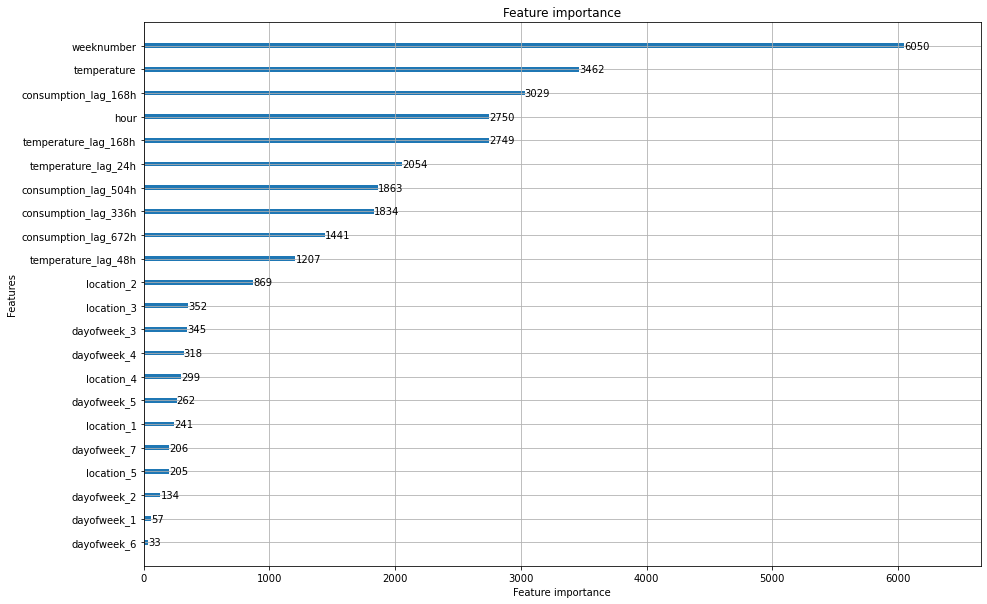

In [ ]:
lgb.plot_importance(model, figsize=(15,10))

In [19]:
from sklearn.ensemble import RandomForestRegressor

RFG_model = RandomForestRegressor(random_state=0, n_estimators=100)

In [20]:
RandomForest_preds = []

for batch in range(len(train_sets_xg)):

    Y_train = train_sets_xg[batch]['consumption'].copy()
    X_train = train_sets_xg[batch].copy()
    X_train.reset_index(drop=True, inplace=True)
    X_train.drop('consumption', axis=1, inplace=True)
    X_train.fillna(0, inplace=True)

    Y_test = test_sets_xg[batch]['consumption'].copy()
    X_test = test_sets_xg[batch].copy()
    X_test.reset_index(drop=True, inplace=True)
    X_test.drop('consumption', axis=1, inplace=True)
    X_test.fillna(0, inplace=True)

    #reg.fit(X_train, Y_train, verbose = True)
    RFG_model.fit(X_train, Y_train)
    RandomForest_preds.append(RFG_model.predict(X_test))

    print('Finished round ' + str(batch) + ' of training')

Finished round 0 of training
Finished round 1 of training
Finished round 2 of training
Finished round 3 of training
Finished round 4 of training
Finished round 5 of training
Finished round 6 of training
Finished round 7 of training
Finished round 8 of training
Finished round 9 of training
Finished round 10 of training
Finished round 11 of training
Finished round 12 of training
Finished round 13 of training
Finished round 14 of training
Finished round 15 of training
Finished round 16 of training
Finished round 17 of training
Finished round 18 of training
Finished round 19 of training
Finished round 20 of training
Finished round 21 of training
Finished round 22 of training
Finished round 23 of training
Finished round 24 of training
Finished round 25 of training
Finished round 26 of training
Finished round 27 of training
Finished round 28 of training
Finished round 29 of training
Finished round 30 of training
Finished round 31 of training
Finished round 32 of training
Finished round 33 of

In [8]:
LGBM_preds = pd.read_csv('lgbm_preds.csv')
RandomForest_preds = pd.read_csv('random_forest_preds.csv')

In [16]:
LGBM_preds.iloc[-14]

0       3.481986
1      10.838456
2       5.333157
3       2.270466
4       3.932563
         ...    
115     3.478710
116    11.232148
117     5.456301
118     2.299097
119     3.852325
Name: 250, Length: 120, dtype: float64

In [19]:
locations = ['Bergen', 'Oslo', 'Stavanger', 'Tromsø' ,'Trondheim' ]

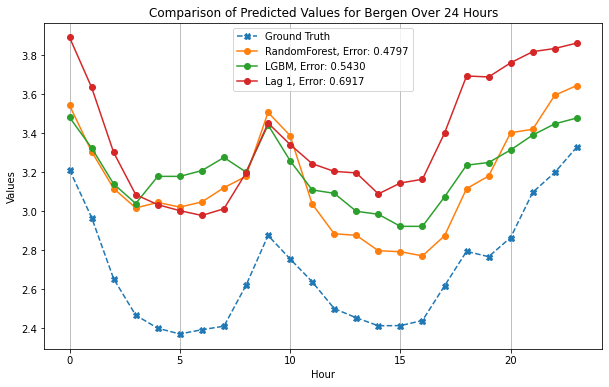

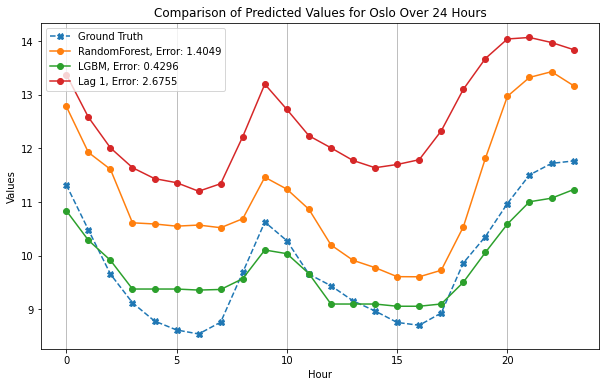

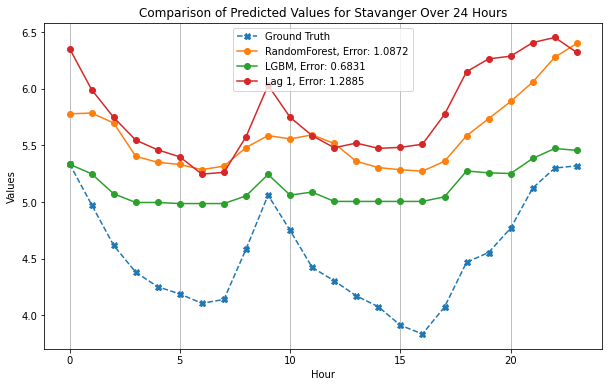

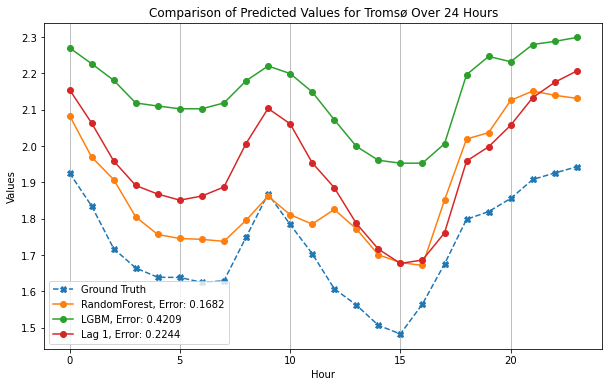

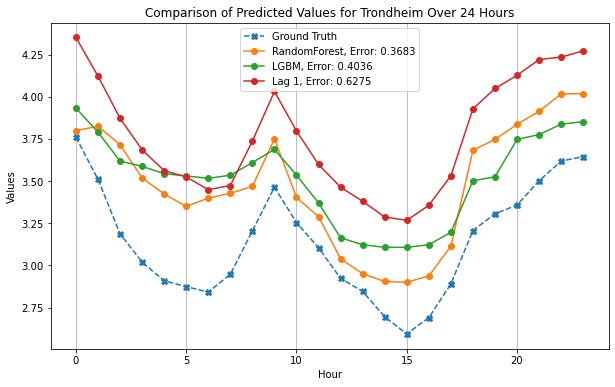

In [24]:
num_cities = 5
num_samples_per_city = 24  # Assuming you have 24 hours of data for each city
total_samples = num_cities * num_samples_per_city
hours = np.arange(num_samples_per_city)

# Plotting for each city
for city in range(num_cities):
    city_indices = np.arange(city, total_samples, num_cities)

    plt.figure(figsize=(10, 6))

    error_lgbm = sqrt(mean_squared_error(LGBM_preds.iloc[-14][city_indices], test_sets_xg[-14]['consumption'][city_indices]))
    error_lag1 = sqrt(mean_squared_error(test_sets_xg[-14]['consumption_lag_168h'][city_indices], test_sets_xg[-14]['consumption'][city_indices]))
    error_rf = sqrt(mean_squared_error(RandomForest_preds.iloc[-14][city_indices], test_sets_xg[-14]['consumption'][city_indices]))

    plt.plot(hours, test_sets_xg[-14]['consumption'][city_indices], label='Ground Truth', linestyle='--', marker='X')
    plt.plot(hours, RandomForest_preds.iloc[-14][city_indices], label=f'RandomForest, Error: {error_rf:.4f}', linestyle='-', marker='o')
    plt.plot(hours, LGBM_preds.iloc[-14][city_indices], label=f'LGBM, Error: {error_lgbm:.4f}', linestyle='-', marker='o')
    plt.plot(hours, test_sets_xg[-14]['consumption_lag_168h'][city_indices], label=f'Lag 1, Error: {error_lag1:.4f}', linestyle='-', marker='o')

    plt.title(f'Comparison of Predicted Values for {locations[city]} Over 24 Hours')
    plt.xlabel('Hour')
    plt.ylabel('Values')
    plt.grid(visible=True, axis='x')
    plt.legend()
    plt.show()


In [26]:
total_rmse_lgbm = []
total_rmse_lag1 = []
total_rmse_randomforest = []

for i in range(len(LGBM_preds)):
    total_rmse_lgbm.append(sqrt(mean_squared_error(LGBM_preds.iloc[i], test_sets_xg[i]['consumption'])))
    total_rmse_lag1.append(sqrt(mean_squared_error(test_sets_xg[i]['consumption_lag_168h'], test_sets_xg[i]['consumption'])))
    total_rmse_randomforest.append(sqrt(mean_squared_error(RandomForest_preds.iloc[i], test_sets_xg[i]['consumption'])))


In [27]:
# Calculate the mean of each error rate list
lgbm_mean = np.mean(total_rmse_lgbm)
lag1_mean = np.mean(total_rmse_lag1)
rf_mean = np.mean(total_rmse_randomforest)

# Print the means
print(f"Mean Error Rate LGBM: {lgbm_mean}")
print(f"Mean Error Rate RandomForest: {rf_mean}")
print(f"Mean Error Rate Lag1: {lag1_mean}")



Mean Error Rate LGBM: 0.40570802006631296
Mean Error Rate RandomForest: 0.5220699855547558
Mean Error Rate Lag1: 0.6154607060411035


In [55]:
train, test = split_dataset(df)

In [61]:
df.index[0] + pd.DateOffset(months=3,days=5)

Timestamp('2022-07-12 21:00:00')

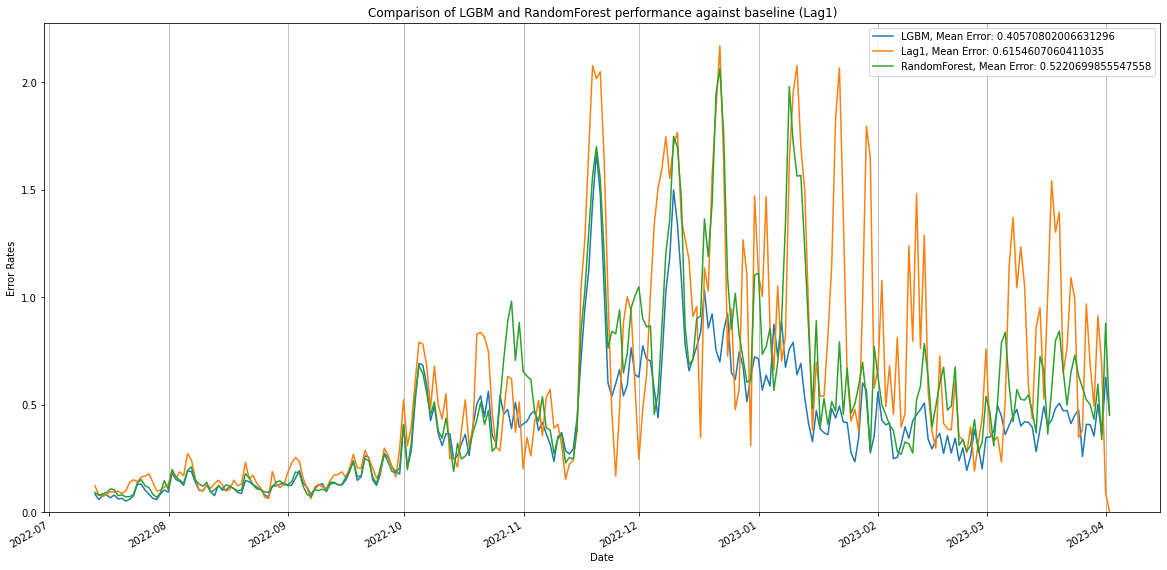

In [29]:
from matplotlib.dates import date2num
# Input start date
start_date = df.index[0] + pd.DateOffset(months=3,days=5)

# Generate dates based on the start date
dates = [start_date + timedelta(days=i) for i in range(len(total_rmse_lgbm))]

# Convert datetime objects to numerical values for plotting
num_dates = date2num(dates)

# Plotting
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.plot(num_dates, total_rmse_lgbm, label=f'LGBM, Mean Error: {lgbm_mean}')
plt.plot(num_dates, total_rmse_lag1, label=f'Lag1, Mean Error: {lag1_mean}')
plt.plot(num_dates, total_rmse_randomforest, label=(f'RandomForest, Mean Error: {rf_mean}'))


# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Error Rates')
plt.title('Comparison of LGBM and RandomForest performance against baseline (Lag1)')
plt.ylim(bottom=0)
plt.grid(axis='x')

# Formatting x-axis as dates
plt.gca().xaxis_date()
plt.gcf().autofmt_xdate()

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [31]:
out = pd.DataFrame(RandomForest_preds)
out.to_csv('random_forest_preds.csv',index=False)

In [219]:
lgbmsave = pd.DataFrame(LGBM_preds)
lgbmsave.to_csv('lgbm_preds.csv', index=False)